In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from spectral import open_image, envi
from sklearn.preprocessing import MinMaxScaler
import re

# spatial
import xarray as xa
import rasterio
import pyproj
import rioxarray
import xesmf as xe

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import joblib


from sklearn.metrics import r2_score
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from statsmodels.multivariate.manova import MANOVA

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting, ml_utils

In [2]:
# load scene
kaneohe_hs = xa.open_dataset(file_ops.TMP_DIR_FP / "kaneohe_hs_masked.nc")
kaneohe_hs = kaneohe_hs["spectra"]
kaneohe_hs.rio.write_crs("EPSG:4326", inplace=True)

<xarray.DataArray 'spectra' (band: 246, lat: 1045, lon: 863)> Size: 887MB
[221851410 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 8kB 21.44 21.44 21.44 21.44 ... 21.52 21.52 21.52
  * lon          (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8 -157.8
  * band         (band) float64 2kB 350.7 353.5 356.4 ... 1.043e+03 1.046e+03
    spatial_ref  int64 8B 0
Attributes:
    driver:   ENVI
    dtype:    float32
    width:    863
    height:   1045
    count:    246

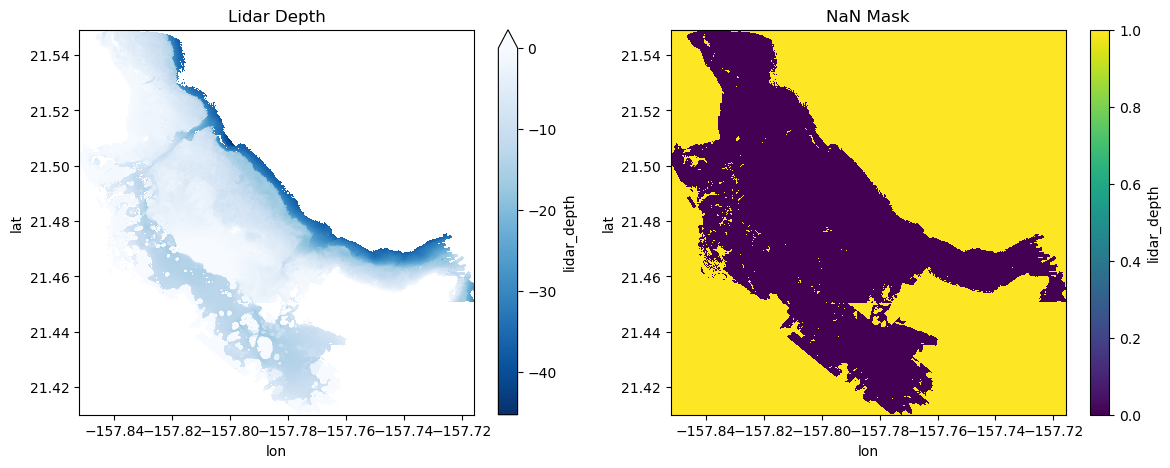

In [77]:
# load lidar

# Load the .grd file
grd_fp = file_ops.DATA_DIR_FP / "lidar/kaneohe_bathy_4m/kaneohe_MB_Lidar_4m.grd"
ds = file_ops.load_grd_to_xarray(grd_fp)
    
# Process and reproject the dataset
fig, ax = plt.subplots(1,2, figsize=(14,5))
lidar_xa = file_ops.process_grd_dataset(ds, src_crs="EPSG:32604")
lidar_xa = lidar_xa.lidar_depth
lidar_xa.rio.set_spatial_dims("lon", "lat", inplace=True)

lidar_xa.plot(vmax=0, cmap="Blues_r", ax=ax[0])
np.isnan(lidar_xa).plot(ax=ax[1])
lidar_xa.rio.write_nodata(np.nan, inplace=True)
ax[0].set_title("Lidar Depth")
ax[1].set_title("NaN Mask");

In [71]:
# load depth
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
# mask depth
depth_trained_model = joblib.load(file_ops.MODELS_DIR_FP / "20241004-125736/best_rf_depth_no_kaneohe.pkl")
depth_rf_inferred = ml_utils.infer_on_spatial(depth_trained_model, kaneohe_hs, ["depth"])

depth_trained_mlp_model = joblib.load(file_ops.MODELS_DIR_FP / "20241004-132443/best_mlp_depth_no_kaneohe.pkl")
depth_mlp_inferred = ml_utils.infer_on_spatial(depth_trained_mlp_model, kaneohe_hs, ["depth"])

# scale depth values according to validation data
depth_rf_inferred["rf_depth_pred"] = depth_rf_inferred["depth_pred"] * np.max(validation_data.Depth)
depth_mlp_inferred["mlp_depth_pred"] = depth_mlp_inferred["depth_pred"] * np.max(validation_data.Depth)
depth_rf_inferred.rf_depth_pred.rio.write_nodata(np.nan, inplace=True)
depth_mlp_inferred.mlp_depth_pred.rio.write_nodata(np.nan, inplace=True)

# merge 
inferred_depth_ds = xa.merge([depth_rf_inferred["rf_depth_pred"], depth_mlp_inferred["mlp_depth_pred"]], compat="override")
# rio formatting
inferred_depth_ds.rio.write_crs(kaneohe_hs.rio.crs, inplace=True)
inferred_depth_ds.rio.set_spatial_dims("lon", "lat", inplace=True)

<xarray.Dataset> Size: 14MB
Dimensions:         (lat: 1045, lon: 863)
Coordinates:
  * lat             (lat) float64 8kB 21.44 21.44 21.44 ... 21.52 21.52 21.52
  * lon             (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8
    spatial_ref     int64 8B 0
Data variables:
    rf_depth_pred   (lat, lon) float64 7MB nan nan nan nan ... nan nan nan nan
    mlp_depth_pred  (lat, lon) float64 7MB nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:  nan

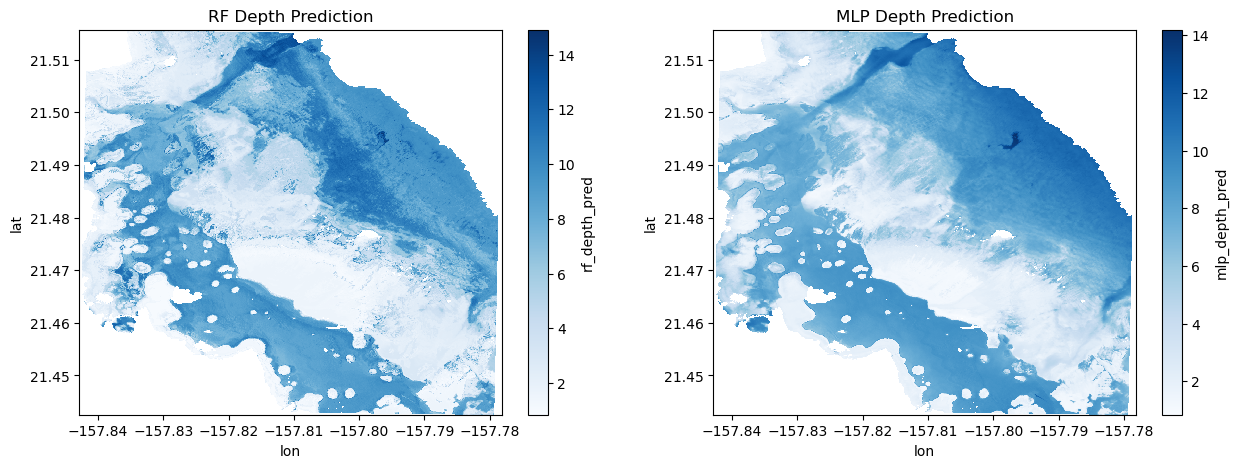

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
inferred_depth_ds["rf_depth_pred"].plot.imshow(ax=ax[0], cmap="Blues")
ax[0].set_title("RF Depth Prediction")
inferred_depth_ds["mlp_depth_pred"].plot.imshow(ax=ax[1], cmap="Blues")
ax[1].set_title("MLP Depth Prediction");

In [84]:
xa_for_reprojecting = inferred_depth_ds["rf_depth_pred"]
xa_for_reprojecting.rio.set_spatial_dims("lon", "lat", inplace=True)

<xarray.DataArray 'rf_depth_pred' (lat: 1045, lon: 863)> Size: 7MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat          (lat) float64 8kB 21.44 21.44 21.44 21.44 ... 21.52 21.52 21.52
  * lon          (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8 -157.8
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

In [85]:
# reproject lidar to match kaneohe_hs spatial resolution
reprojected_lidar = lidar_xa.rio.reproject_match(xa_for_reprojecting,
                                                nodata=np.nan,
                                                 )
reprojected_lidar = reprojected_lidar.where(reprojected_lidar != 0, np.nan)
# rename x and y diemnsions to lon and lat
reprojected_lidar = reprojected_lidar.rename({"x": "lon", "y": "lat"})
reproected_lidar = reprojected_lidar.rio.set_spatial_dims("lon", "lat", inplace=True)
# combine inferred dataset and lidar new dataset
depth_merged = xa.merge([reprojected_lidar, inferred_depth_ds])
rf_prediction_vals = depth_merged["rf_depth_pred"].values.flatten()
mlp_prediction_vals = depth_merged["mlp_depth_pred"].values.flatten()

In [28]:
# mask prediction dataset by lidar nans
masked_depth_merged = depth_merged.where(~np.isnan(reprojected_lidar["lidar_depth"]))

In [81]:
reprojected_lidar.rio.nodata

nan

In [87]:
reprojected_lidar

<xarray.DataArray 'lidar_depth' (lat: 1045, lon: 863)> Size: 7MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    spatial_ref  int64 8B 0
  * lon          (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8 -157.8
  * lat          (lat) float64 8kB 21.44 21.44 21.44 21.44 ... 21.52 21.52 21.52
Attributes:
    _FillValue:  nan

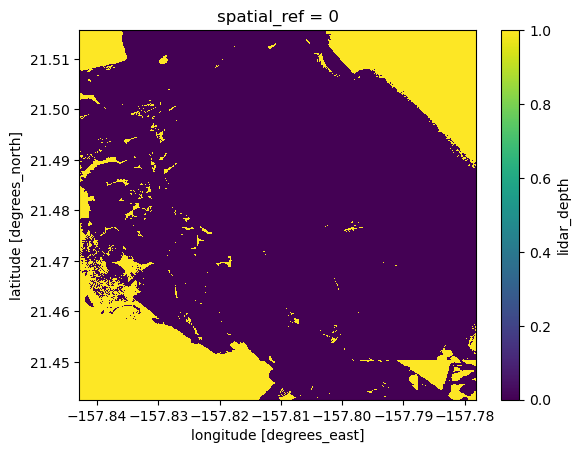

In [86]:
np.isnan(reprojected_lidar).plot()

# reprojected_lidar

In [34]:
# visualise where
np.isnan(reprojected_lidar["lidar_depth"])

<xarray.DataArray 'lidar_depth' (lat: 1045, lon: 863)> Size: 902kB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
    spatial_ref  int64 8B 0
  * lon          (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8 -157.8
  * lat          (lat) float64 8kB 21.44 21.44 21.44 21.44 ... 21.52 21.52 21.52
Attributes:
    _FillValue:  nan

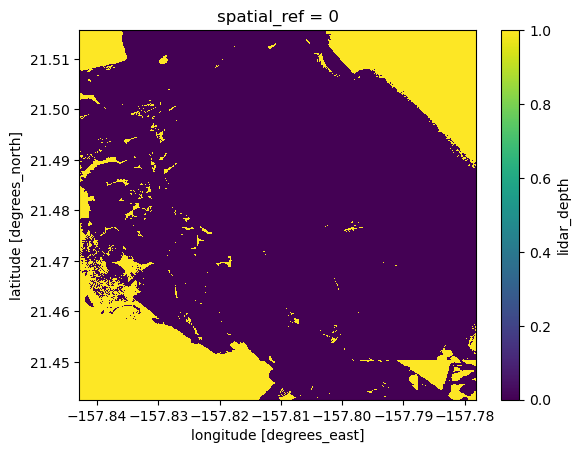

In [35]:
np.isnan(reprojected_lidar["lidar_depth"]).plot()

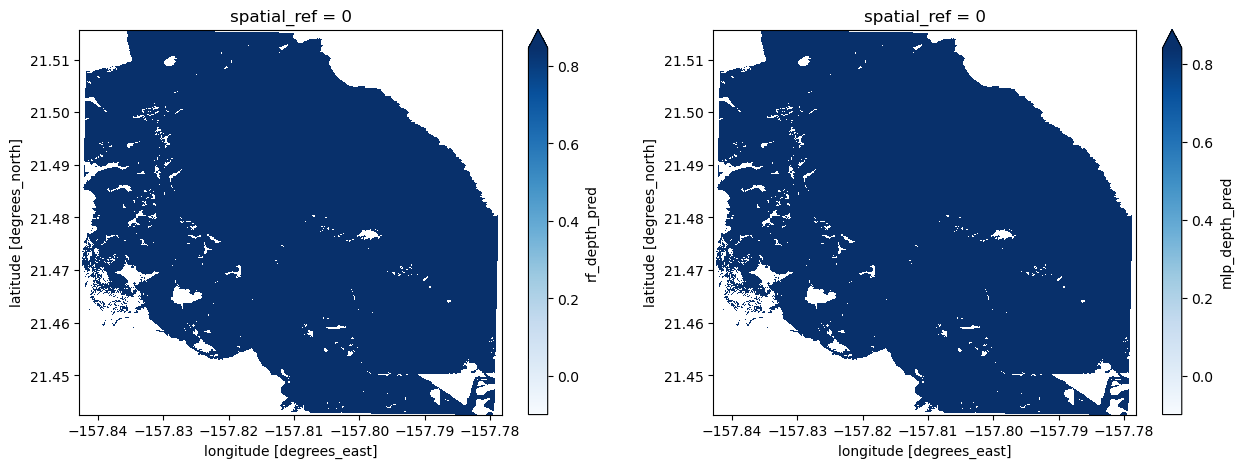

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
masked_depth_merged["rf_depth_pred"].plot.imshow(vmax=0, cmap="Blues", ax=ax[0])
masked_depth_merged["mlp_depth_pred"].plot.imshow(vmax=0, cmap="Blues", ax=ax[1])

In [54]:
# drop nans/inf values from lidar_vals
reprojected_lidar.lidar_depth.values[np.isinf(reprojected_lidar.lidar_depth.values)] = np.nan

In [56]:
reprojected_lidar.lidar_depth.values[np.isinf(reprojected_lidar.lidar_depth.values)] = np.nan
reprojected_lidar_values = reprojected_lidar.lidar_depth.values.flatten()
no_nan_lidar_vals = reprojected_lidar_values[~np.isnan(reprojected_lidar_values)]
no_nan_lidar_vals.shape

(710120,)

In [48]:
no_nan_rf_prediction_vals = rf_prediction_vals[~np.isnan(rf_prediction_vals)]
no_nan_rf_prediction_vals.shape

(686658,)

ValueError: Input contains infinity or a value too large for dtype('float64').

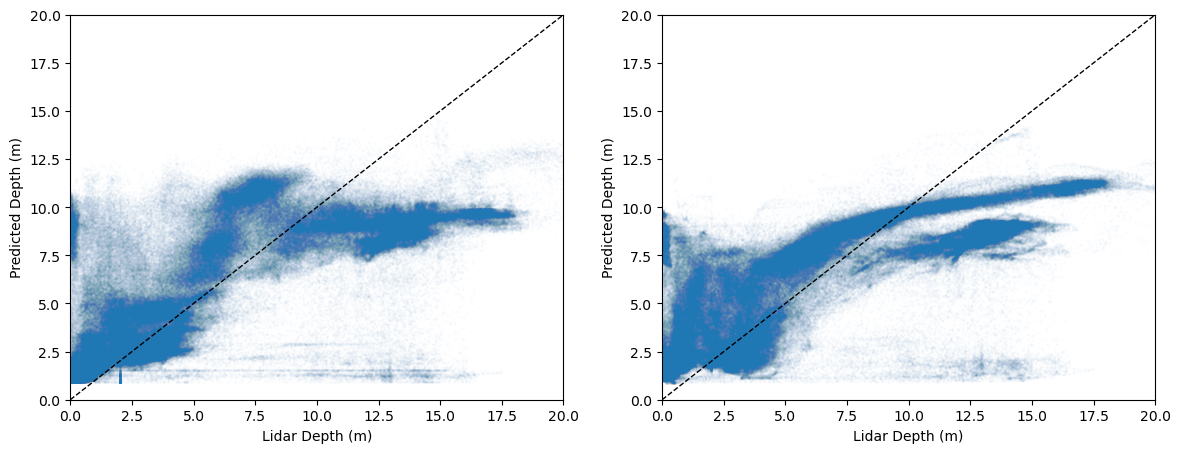

In [39]:
from sklearn.metrics import r2_score
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# plot scatter of test and lidar
lidar_vals = np.abs(depth_merged["lidar_depth"].values.flatten())

axs[0].scatter(lidar_vals, rf_prediction_vals, s=1, alpha=0.01)
max_val = max(np.nanmax(rf_prediction_vals), np.nanmax(lidar_vals))
axs[1].scatter(lidar_vals, mlp_prediction_vals, s=1, alpha=0.01)
[ax.plot([0, 20], [0, 20], color="k", lw=1, ls="--") for ax in axs]
[ax.set_xlabel("Lidar Depth (m)") for ax in axs]
[ax.set_ylabel("Predicted Depth (m)") for ax in axs]
[ax.set_xlim(0, 20) for ax in axs]
[ax.set_ylim(0, 20) for ax in axs];
axs[0].set_title(f"RF Depth Prediction\n{r2_score(lidar_vals, rf_prediction_vals):.2f} R2 Score");
axs[1].set_title(f"MLP Depth Prediction\n{r2_score(lidar_vals, mlp_prediction_vals):.2f} R2 Score");

In [14]:
hs_vals = pd.DataFrame(kaneohe_hs.spectra.values.reshape(kaneohe_hs.sizes["band"], -1).T, columns=kaneohe_hs.band.values)
# process: deglint and crop to sensor range
hs_vals = spectrum_utils.deglint_spectra(hs_vals)
hs_vals = spectrum_utils.crop_spectra_to_range(hs_vals)

In [ ]:
# append lidar depths for ml training


In [ ]:
all_depths = ml_utils.spectral_xa_to_processed_spectral_df(reprojected_lidar.lidar_depth)
# all_depths_scaled = ml_utils.process_df_for_inference(all_depths)

KeyError: 'band'

In [ ]:
all_spectra_scaled

In [ ]:
# fit depth using linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# remove nans
lidar_vals = lidar_vals[~np.isnan(prediction_vals)]
prediction_vals = prediction_vals[~np.isnan(prediction_vals)]

lr = LinearRegression()
lr.fit(lidar_vals.reshape(-1, 1), prediction_vals)
r2_score(lidar_vals, prediction_vals)


In [88]:
results_fp = "/Users/rt582/Desktop/results_summary.csv"

import ast  # To convert string representations of lists to actual lists

# Define custom converters for list columns
def list_converter(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except (ValueError, SyntaxError):
        return val

# Load CSV with correct data types
results_df = pd.read_csv(results_fp, 
                 header=[0,1],
                 parse_dates=[('metadata','datetime (UTC)')],  # Assuming 'metadata' is a datetime column in the multi-index
                 converters={
                     ('processing', 'nir_wavelengths'): list_converter,
                     ('processing', 'sensor_range'): list_converter,
                     ('processing', 'endmember_bounds'): list_converter,
                     ('processing', 'endmember_dimensionality_reduction'): list_converter,
                     ('fitting', 'bb_bounds'): list_converter,
                     ('fitting', 'Kd_bounds'): list_converter,
                     ('fitting', 'H_bounds'): list_converter,
                    ('simulation', 'Rb_vals'): list_converter,
                    ('simulation', 'depth_lims'): list_converter,
                    ('simulation', 'k_lims'): list_converter,
                    ('simulation', 'bb_lims'): list_converter,
                    ('simulation', 'noise_lims'): list_converter,
                     ('processing', 'endmember_source'): lambda x: x if x != 'None' else None,  # Convert 'None' strings to None
                     ('processing', 'save_fits'): lambda x: x == 'True',  # Convert to boolean
                 }
)

In [95]:
sub_df = results_df
sub_df = results_df
best_row = sub_df.loc[sub_df['r2', 'mean'].idxmax()]
best_row.r2

# Initialize the dictionary
best_cfg_params_dict = {
    'processing': {},
    'simulation': {},
    'fitting': {}
}

for (level_0, level_1) in best_row.index:
    value = best_row[(level_0, level_1)]
    if level_0 in best_cfg_params_dict:
        if not isinstance(value, list):
            value = None if pd.isna(value) else value
            
        best_cfg_params_dict[level_0][level_1] = value

In [99]:
g_cfg

GlobalOptPipeConfig(spectra_source='kaneohe', spectra_fp=PosixPath('/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/CORAL_validation_spectra.csv'), spectral_library_fp=PosixPath('/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/resources/spectral_library_clean_v3_PRISM_wavebands.csv'), validation_data_fp=PosixPath('/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/CORAL_validation_data.csv'), save_fits=True, endmember_map={'algae_crustose_coralline': ['algCCA'], 'algae_fleshy_brown': ['algMacBrn'], 'algae_fleshy_green': ['algMacGrn', 'algMacMix', 'algMacUnk', 'algCyano'], 'algae_fleshy_red': ['algMacRed'], 'algae_turf': ['algTurf'], 'coral_blue': [], 'coral_brown': ['crlCoral'], 'mud': ['sedMud'], 'octocoral': ['othOcto'], 'sand': ['sedSand', 'crlBleach', 'sedLimest', 'sedRubble'], 'seagrass': ['othSeagr']}, endmember_schema=

In [ ]:
# run pipeline with cfg
g_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
g_cfg.save_fits = True
g_cfg.spectra_source = "kaneohe"
cfg = file_ops.RunOptPipeConfig(best_cfg_params_dict)

pipe = optimisation_pipeline.OptPipe(g_cfg, cfg)
fit_results = pipe.run()

Fitting spectra:   0%|          | 0/686658 [00:00<?, ?it/s]

In [93]:
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)
wvs = AOP_model.index
AOP_sub = AOP_model.loc[wvs]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)

NameError: name 'aop_args' is not defined

In [ ]:
# fit depth using physical model
of = spectrum_utils.r2_objective_unity_fn


partial_wrapper = partial(
            spectrum_utils._wrapper,
            of=of,
            obs_spectra=spectra,
            AOP_args=AOP_args,
            endmember_array=endmembers.values,
            Rb_init=cfg.Rb_init,
            bb_bounds=cfg.bb_bounds,
            Kd_bounds=cfg.Kd_bounds,
            H_bounds=cfg.H_bounds,
            endmember_bounds=cfg.endmember_bounds,
            solver=cfg.solver,
            tol=cfg.tol,
        )

        # if self.exec_kwargs["tqdm"]:
        fitted_params = Parallel(n_jobs=128)(
            delayed(partial_wrapper)(index)
            for index in tqdm(self.spectra.index, miniters=10, desc="Fitting spectra")
        )

        self.fitted_params = pd.DataFrame(
            fitted_params,
            index=self.spectra.index,
            columns=["bb", "K", "H"] + list(list(self.endmembers.index)),
        )
